In [ ]:
import numpy as np

def gamma_candidates(gamma):
    gamma = np.array(gamma)
    q = len(gamma)

    # Create the (2q, q) matrix
    gammas = np.tile(gamma, (2*q, 1))

    # Set specific rows to 0 and 1
    for i in range(q):
        gammas[i, i] = 0
        gammas[q + i, i] = 1

    # Remove duplicate rows
    gammas = np.unique(gammas, axis=0)

    # Filtering conditions
    not_all_ones = ~np.all(gammas == 1, axis=1)
    not_only_one_1 = np.sum(gammas, axis=1) != 1
    not_same_as_gamma = ~np.all(gammas == gamma, axis=1)

    # Apply all filters
    valid = not_all_ones & not_only_one_1 & not_same_as_gamma
    gammas = gammas[valid]

    return gammas


In [ ]:
import numpy as np

def logsumexp(x):
    """
    Compute the log-sum-exp and softmax of a vector x in a numerically stable way.

    Parameters:
    x (numpy array): Input vector.

    Returns:
    lse (float): Log-sum-exp of the input vector.
    sm (numpy array): Softmax of the input vector.
    """
    if x.ndim != 1:
        raise ValueError("Input x must be a vector.")

    xmax = np.max(x)
    e = np.exp(x - xmax)
    s = np.sum(e) - e[np.argmax(x)]  # Exclude max element from sum
    lse = xmax + np.log1p(s)  # log1p(s) = log(1 + s)

    sm = e / (1 + s)  # Softmax vector
    return lse, sm


In [ ]:
import numpy as np
from scipy.linalg import lu, cholesky
from numpy.linalg import LinAlgError

def logdet(A, method=None):
    """
    Computes the logarithm of the determinant of a matrix A.

    Parameters:
    A (ndarray): A square matrix.
    method (str, optional): 'chol' to use Cholesky decomposition
                            (only for positive-definite matrices).

    Returns:
    float: The log-determinant of the matrix.
    """
    A = np.asarray(A)

    # Argument check
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("Input A must be a square matrix.")

    if method is None:
        use_chol = False
    elif isinstance(method, str) and method.lower() == 'chol':
        use_chol = True
    else:
        raise ValueError("Second argument must be either None or 'chol'.")

    try:
        if use_chol:
            # Cholesky decomposition (for positive-definite matrices)
            L = cholesky(A, lower=True)
            return 2 * np.sum(np.log(np.diag(L)))
        else:
            # LU decomposition (for generic square matrices)
            P, L, U = lu(A)
            du = np.diag(U)
            sign_c = np.linalg.det(P) * np.prod(np.sign(du))
            if sign_c == 0:
                return -np.inf  # Singular matrix
            return np.log(abs(sign_c)) + np.sum(np.log(np.abs(du)))
    except LinAlgError:
        return -np.inf  # Matrix is singular or not factorizable


In [ ]:
import numpy as np
from scipy.stats import beta, norm

def sample_phi_slice(phih, h, muh, sig2h, a0, b0):
    """
    Slice sampling of phi from its posterior using a discrete grid.

    Parameters:
    phih : float
        Current value of phi.
    h : np.ndarray
        Time series vector.
    muh : float
        Mean parameter.
    sig2h : float
        Variance parameter.
    a0, b0 : float
        Beta prior parameters.

    Returns:
    phih : float
        New sampled phi.
    uu : float
        Uniform auxiliary variable used for slice sampling.
    """

    # Discretized set of possible phi values in [-1, 1]
    phi_set = np.linspace(-1, 1, 100)

    # Define the target posterior density (unnormalized)
    def func_phi(phi):
        prior = beta.pdf((phi + 1) / 2, a0, b0)  # transform phi ∈ [-1, 1] to [0, 1]
        likelihood = norm.pdf(h[1:], loc=muh + phi * (h[:-1] - muh), scale=np.sqrt(sig2h))
        return prior * np.sum(likelihood)

    # Draw auxiliary slice height
    uu = np.random.uniform(0, func_phi(phih))

    # Evaluate func_phi over the phi_set
    values = np.array([func_phi(phi) for phi in phi_set])

    # Accept set: values where func_phi >= uu
    accept_indices = values >= uu
    accepted_phi_set = phi_set[accept_indices]

    # Randomly sample new phi from accepted values
    phih = np.random.choice(accepted_phi_set)

    return phih, uu



In [ ]:
import numpy as np
from numpy.linalg import cholesky, solve, LinAlgError
from numpy.linalg import pinv

def HansenIMLE(Y, X, r, qg, SigmaHinv, tol=1e-4, maxIter=500):
    """
    Solve for C1hat via the Hansen IMLE iterative procedure.

    Parameters
    ----------
    Y : ndarray, shape (n, q)
        Response matrix.
    X : ndarray, shape (n, p)
        Predictor matrix.
    r : int
        Rank parameter.
    qg : int
        The number of responses in the low-rank group.
    SigmaHinv : ndarray, shape (n*q, n*q)
        Precomputed inverse matrix.
    tol : float, optional
        Convergence tolerance (default: 1e-4).
    maxIter : int, optional
        Maximum number of iterations (default: 500).

    Returns
    -------
    C1hat : ndarray, shape (p, qg)
        The estimated matrix.
    """
    # Dimensions
    n, q = Y.shape
    p = X.shape[1]
    q2 = q - qg

    # Iq = identity matrix of size q
    Iq = np.eye(q)

    # V1 = [I_{qg}, zeros(qg, q2)] so that V1 is of shape (qg, q)
    V1 = np.hstack((np.eye(qg), np.zeros((qg, q2))))

    #%% Commutation matrix Kpr
    # In MATLAB:
    #   idx = reshape(1:p*r, [p,r])';
    #   Kpr = speye(p*r);
    #   Kpr = Kpr(idx(:),:);
    #
    # In Python, create the index array (note MATLAB is 1-indexed; here we use 0-indexing)
    pr = p * r
    # Create array with MATLAB’s column‐major order:
    arr = np.arange(1, pr+1).reshape((p, r), order='F')
    # Transpose and flatten to get the new ordering, and convert to 0-indexed:
    idx_order = (arr).flatten(order = 'F') - 1
    # Commutation matrix: start with identity and reorder its rows
    Kpr = np.eye(pr)[idx_order, :]

    #%% INITIAL VALUES
    Bhat = np.random.randn(p, r)
    Ahat = np.random.randn(qg, r)
    # V1tAhat = V1' * Ahat; note: V1' in MATLAB is the transpose.
    V1tAhat = V1.T @ Ahat
    # V1star = pinv(V1')
    V1star = pinv(V1.T)

    idx_list = []
    for l in range(0, qg - r):
        # MATLAB: (qg - l) : q : (q*r)
        # In Python, the first element is (qg - l) (but subtract 1 for zero-index)
        start = (qg - l) - 1
        # Last value should not exceed q*r-1.
        stop = q * r  # np.arange stops before this value
        idx_range = np.arange(start, stop, q)
        idx_list.append(idx_range)
    # Concatenate and sort indices
    idx = np.sort(np.concatenate(idx_list))

    # G is a selector matrix of shape (q*r, (qg-r)*r) with ones along (idx, :)
    num_cols_G = (qg - r) * r
    G = np.zeros((q * r, num_cols_G))
    # In MATLAB, the nonzero entries in G are placed in columns 1:num_cols_G in order.
    # We assume there are exactly num_cols_G indices in idx.
    if len(idx) != num_cols_G:
        raise ValueError("Dimension mismatch when constructing G.")
    for i in range(num_cols_G):
        G[idx[i], i] = 1.0

    # Construct vector g. MATLAB: g = sparse(1:(q+1):(q*r),1, 1, q*r, 1);
    # This creates a vector of length (q*r) with ones at indices 1, 1+q, 1+2q,... (1-indexed).
    # In Python (0-indexed):
    g = np.zeros((q * r, 1))
    indices_g = np.arange(0, q * r, q + 1)
    g[indices_g, 0] = 1.0

    # yvec = vec(Y') i.e., stack columns of Y
    yvec = Y.T.reshape(-1, 1, order = 'F')

    noconv = True
    j = 1

    while noconv:
        j += 1
        V1tAold = V1tAhat.copy()
        Bold = Bhat.copy()

        #%% Estimate Ahat
        # XBI = kron(X*Bhat, Iq)
        XB = X @ Bhat        # shape: (n, r)
        XBI = np.kron(XB, Iq) # shape: (n*q, r*q)  [because kron produces block structure]

        AA = XBI.T @ SigmaHinv   # shape: (r*q, n*q)
        NB = AA @ yvec           # shape: (r*q, 1)
        MB = AA @ XBI            # shape: (r*q, r*q)

        # Solve for alphahat: //MY TRY
        # alphahat = G * ((G' * MB * G) \ (G' * (NB - MB * g))) + g
        M_temp = G.T @ MB @ G  # shape: ((qg-r)*r, (qg-r)*r)
        rhs = G.T
        to_mul = (NB - MB @ g)  # shape: ((qg-r)*r, 1)
        # Solve linear system; if M_temp is singular, this will raise an error.
        sol = np.linalg.solve(M_temp, rhs)
        sol = sol @ to_mul
        alphahat = G @ sol + g   # shape: (q*r, 1)

        # Reshape alphahat to (q, r) i.e., q rows, r columns.
        V1tAhat = alphahat.reshape(r, q).T

        #%% Estimate Bhat
        # XV1A = kron(X, V1tAhat)
        XV1A = np.kron(X, V1tAhat)  # shape: (n*q, p*r) where each block is weighted by V1tAhat.

        # kkpr_tmp = (XV1A * Kpr)' * SigmaHinv;
        kkpr_tmp = ((XV1A @ Kpr).T) @ SigmaHinv   # shape: (p*r, n*q)
        NA = kkpr_tmp @ yvec                     # shape: (p*r, 1)
        MA = kkpr_tmp @ (XV1A @ Kpr)             # shape: (p*r, p*r)

        # Solve for betahat, which is vec(Bhat)
        betahat = np.linalg.solve(MA, NA)                  # shape: (p*r, 1)
        Bhat = betahat.reshape((p, r), order = 'F')             # shape: (p, r)

        # Check convergence:
        conv_B = np.all(np.abs(Bhat - Bold) < tol)
        conv_A = np.all(np.abs(V1tAhat - V1tAold) < tol)

        conv_B = np.linalg.norm(Bhat - Bold) < tol
        conv_A = np.linalg.norm(V1tAhat - V1tAold) < tol
        if (conv_B and conv_A) or (j == maxIter):
            noconv = False

    # Compute final outputs.
    Ahat = V1star @ V1tAhat   # shape: (q, r) because V1star is pinv(V1')
    C1hat = Bhat @ Ahat.T     # shape: (p, q)
    return C1hat



In [ ]:
import numpy as np
from scipy.sparse import eye as speye_sparse, csr_matrix
from scipy.linalg import cholesky, solve
from numpy.linalg import LinAlgError

def posterior_gamma(Y, X, Sigma, d, gamma, rho, Knq, Kqn):
    """
    Compute the posterior gamma based on the given data.

    Parameters
    ----------
    Y : ndarray, shape (n, q)
        Response matrix.
    X : ndarray, shape (n, p)
        Predictor matrix.
    Sigma : ndarray, shape (q, q)
        Covariance matrix for the responses.
    d : float
        Scalar to build Sigma_delta.
    gamma : ndarray
        Initial gamma vector.
    rho : float
        Prior parameter for gamma.
    Knq : ndarray
        Matrix used in building SigmaH.
    Kqn : ndarray
        Matrix used in building SigmaH.

    Returns
    -------
    ptilde : ndarray
        The posterior probability mass function of gamma (softmax over lognum).
    lognum : ndarray
        Log-numerators for each candidate gamma.
    gammas : ndarray
        Candidate gamma matrix (each row is a candidate).
    logf_r : ndarray
        Evaluated Laplace approximation functions for each candidate gamma and rank.
    """
    n, q = Y.shape
    p = X.shape[1]

    # Generate candidate gamma vectors:
    gammas = gamma_candidates(gamma)
    ngammas = gammas.shape[0]
    # In MATLAB: rmax = min(p, max(sum(gammas,2))) - 1;
    rmax = min(p, int(np.max(np.sum(gammas, axis=1)))) - 1

    # Allocate storage (MATLAB: NaN array for logf_r of size [ngammas, rmax])
    logf_r = np.full((ngammas, rmax), np.nan)
    logf_gamma = np.zeros(ngammas)  # likelihood gamma (log Eq.(19))
    logp_gamma = np.zeros(ngammas)  # prior gamma (log Eq.(3))

    # Loop over candidate gammas
    for j in range(ngammas):
        gammaj = gammas[j, :]
        qgj = int(np.sum(gammaj))    # number of ones in gammaj (low-rank responses)
        q2j = q - qgj
        rmaxj = min(p, qgj) - 1
        # Find indices for low-rank and full-rank groups (MATLAB: find(gammaj == 1), find(gammaj == 0))
        low_r = np.where(gammaj == 1)[0]
        full_r = np.where(gammaj == 0)[0]

        # Reorder responses according to gammaj: Y_new = [Y(:,low_r), Y(:,full_r)]
        Y_new = np.hstack((Y[:, low_r], Y[:, full_r]))
        y = Y_new.reshape(-1, 1, order = 'F')  # vectorize Y_new

        # Reorder Sigma according to gammaj:
        idx = np.concatenate((low_r, full_r))
        Sigma_new = Sigma[np.ix_(idx, idx)]

        # Build Sigma_delta = d * I_{p*q2j}
        Sigma_delta = d * np.eye(p * q2j)

        # Build V1 and V2 (MATLAB: [I, 0] and [0, I])
        V1 = np.hstack((np.eye(qgj), np.zeros((qgj, q2j))))
        V2 = np.hstack((np.zeros((q2j, qgj)), np.eye(q2j)))
        # U1 = kron(V1', X) and U2 = kron(V2', X). Note the transpose.
        U1 = np.kron(V1.T, X)
        U2 = np.kron(V2.T, X)

        # Sigmatilde = kron(Sigma_new, I_n)
        Sigmatilde = np.kron(Sigma_new, np.eye(n))
        # Sigmay = Sigmatilde + U2 * Sigma_delta * U2'
        Sigmay = Sigmatilde + U2 @ Sigma_delta @ U2.T
        # Build SigmaH = Knq * Sigmay * Kqn
        SigmaH = Knq @ Sigmay @ Kqn
        # Compute inverse of SigmaH: SigmaHinv = SigmaH \ I (solve linear system)
        SigmaHinv = solve(SigmaH, np.eye(n * q))

        # Compute constant term in Gaussian density: Eq.(14)
        logf_r1 = -0.5 * n * q * np.log(2 * np.pi) - 0.5 * logdet(Sigmay, method='chol')

        # Loop over possible ranks r = 1 to rmaxj
        for r in range(1, rmaxj + 1):
            # Compute C1hat via HansenIMLE (user must implement HansenIMLE accordingly)
            C1hat = HansenIMLE(Y_new, X, r, qgj, SigmaHinv, tol=1e-4, maxIter=500)
            # Multiply U1 by vectorized C1hat
            U1c1 = U1 @ C1hat.reshape(-1, 1, order = 'F')
            diff = (y - U1c1).flatten(order = 'F') ##PROBLEM POINT
            # Quadratic term: (y - U1c1)' * (Sigmay \ (y - U1c1))
            quad_term = -0.5 * (diff.T @ solve(Sigmay, diff))
            penalty = 0.5 * (p * r + (qgj - r) * r) * np.log(n)
            logf_r[j, r - 1] = logf_r1 + quad_term - penalty

        # For candidate j, compute logf_gamma as logsumexp of logf_r over ranks 1:rmaxj minus log(rmaxj)
        lse_val, _ = logsumexp(logf_r[j, :rmaxj])
        logf_gamma[j] = lse_val - np.log(rmaxj)
        # Compute prior gamma: sum(gammaj*log(rho) + (1-gammaj)*log(1-rho))
        logp_gamma[j] = np.sum(gammaj * np.log(rho) + (1 - gammaj) * np.log(1 - rho))

    # Log numerator: Eq.(20)
    lognum = logf_gamma + logp_gamma
    # Compute posterior gamma probabilities via normalized weights; here we use the softmax from logsumexp.
    _, ptilde = logsumexp(lognum)

    return ptilde, lognum, gammas, logf_r



Reorder


In [ ]:
import numpy as np
from scipy.sparse import csr_matrix, eye as speye

def reorder(Y, X, C, Sigma, d, gamma):
    """
    Reorders responses, covariance matrices, and creates U1/U2 design matrices.

    Parameters:
        Y: (n, q) response matrix
        X: (n, p) design matrix
        C: (p, q) coefficient matrix
        Sigma: covariance matrix (q, q) or (q, q, n)
        d: scalar controlling prior variance
        gamma: (q,) array with binary entries (1 = low-rank group)


    Returns:
        Reordered versions of Y, y (vectorized Y), C, Sigma, Sigmatilde,
        U1, U2 (design matrices), Sigma_delta, qg, q2, ylabel (indexing)
    """
    n, q = Y.shape
    p = X.shape[1]
    gamma = np.array(gamma).astype(int)
    qg = int(np.sum(gamma))
    q2 = q - qg

    low_r = np.where(gamma == 1)[0]
    full_r = np.where(gamma == 0)[0]

    reorder_idx = np.concatenate([low_r, full_r])

    Y = Y[:, reorder_idx]
    y = Y.T.reshape(-1, 1, order = 'F')
    C = C[:, reorder_idx]
    ylabel = reorder_idx

    # Reorder Sigma
    Sigma = Sigma[np.ix_(reorder_idx, reorder_idx)]
    Sigmatilde = np.kron(Sigma, np.eye(n))

    # Build Sigma_delta and U matrices
    Sigma_delta = d * np.eye(p * q2)

    V1 = np.hstack([np.eye(qg), np.zeros((qg, q2))])
    V2 = np.hstack([np.zeros((q2, qg)), np.eye(q2)])
    U1 = np.kron(V1.T, X)
    U2 = np.kron(V2.T, X)

    return Y, y, C, Sigma, Sigmatilde, U1, U2, Sigma_delta, qg, q2, ylabel

In [ ]:
import numpy as np
from scipy.linalg import cholesky, solve, kron
from scipy.stats import beta, invwishart
import math

# Placeholder functions: you must implement these
# def posterior_gamma(Y, X, Sigma, d, gamma, rho, Knq, Kqn):
#     # returns ptilde_gamma, lognum_gamma, gammas, logf_r_prop
# def HansenIMLE(Y, X, r, qg, SigmaHinv, tol=1e-2, maxIter=500):
#     # returns C1hat (p x qg)
# def reorder(Y_in, X, C_in, Sigma_in, d, gamma):
#     # returns Y, y, C, _, Sigmatilde, U1, U2, Sigma_delta, qg, q2, ylabel


def sampler_bprr(Y, X, mcmc, burnin, thin, iprint, gamma=None):
    """
    Bayesian Partial Reduced-Rank Regression sampler.
    """
    nrun = burnin + mcmc
    n, p = X.shape
    q = Y.shape[1]
    Y_in = Y.copy()

    # Initialize gamma
    if gamma is None:
        qg = np.random.randint(2, q)
        gamma = np.zeros(q, dtype=int)
        gamma[:qg] = 1
        np.random.shuffle(gamma)
    else:
        qg = int(np.sum(gamma))
    q2 = q - qg

    # Hyperparameters
    rho = 0.5
    a_rho, b_rho = 1, 1
    a, b, d = 0.5, 0.5, 0.5
    Sigma_delta = d * np.eye(p * q2)

    # Initial C and Sigma
    C_in = np.random.randn(p, q)
    Iq = np.eye(q)
    Ip = np.eye(p)

    # Commutation matrices Knq, Kqn
    idx_arr = np.arange(q * n).reshape((q, n), order='F')
    perm = idx_arr.T.flatten(order='F')
    Knq = np.eye(q * n)[perm, :]
    Kqn = Knq.T

    # Sigma parameters (Inverse-Wishart)
    Psi = Iq.copy()
    nu = q + 1
    Sigma = Iq.copy()
    Sigma_in = Sigma.copy()
    n_final = math.floor(mcmc/thin)
    # Storage
    store_gamma  = np.zeros((n_final, q), dtype=int)
    store_r      = np.zeros(n_final, dtype=int)
    maxrank      = min(p, q)
    store_A      = np.full((n_final, q, maxrank), np.nan)
    store_B      = np.full((n_final, p, maxrank), np.nan)
    store_C2     = np.full((n_final, p, q), np.nan)
    store_acc    = np.zeros(n_final)
    store_ylabel = np.zeros((n_final, q), dtype=int)
    store_Ypred  = np.zeros((n_final, n, q))
    store_Sigma  = np.zeros((n_final, q, q))

    ptr = 0
    for it in range(1, nrun + 1):
        # 1. Sample gamma
        ptilde, lognum, gammas, logf_r_prop = posterior_gamma(
            Y_in, X, Sigma_in, d, gamma, rho, Knq, Kqn
        )
        # draw new gamma
        u = np.random.rand()
        cum = np.concatenate(([0], np.cumsum(ptilde)))
        pos = np.where(u > cum)[0][-1]
        gamma_prop = gammas[pos, :].astype(int)

        # acceptance ratio
        _, lognum_prop, _, _ = posterior_gamma(
            Y_in, X, Sigma_in, d, gamma_prop, rho, Knq, Kqn
        )
        lograte = logsumexp(lognum)[0] - logsumexp(lognum_prop)[0]
        acceptance = min(1.0, np.exp(lograte))

        if np.random.rand() < acceptance:
            gamma = gamma_prop
            logf_r = logf_r_prop[pos, :] #logf_r should have length same as rmax

            # reorder
            Y, y, C, _, Sigmatilde, U1, U2, Sigma_delta, qg, q2, ylabel = \
                reorder(Y_in, X, C_in, Sigma_in, d, gamma)
            rmax = min(p, qg) - 1
            logf_r = logf_r[:rmax]
            #print("accepted")
        else:
            # on first iteration, need reorder
            if it == 1:
                Y, y, C, _, Sigmatilde, U1, U2, Sigma_delta, qg, q2, ylabel = \
                    reorder(Y_in, X, C_in, Sigma_in, d, gamma)
                rmax = min(p, qg) - 1
            # recompute logf_r for current gamma
            Sigmay = Sigmatilde + U2 @ Sigma_delta @ U2.T
            SigmaH = Knq @ Sigmay @ Kqn
            SigmaHinv = np.linalg.solve(SigmaH, np.eye(n * q))
            const = -0.5 * n * q * np.log(2*np.pi) - 0.5 * logdet(Sigmay, 'chol')
            logf_r = np.zeros(rmax)
            for r in range(1, rmax+1):
                C1hat = HansenIMLE(Y, X, r, qg, SigmaHinv)
                vecC = C1hat.flatten(order='F')
                U1c1 = U1 @ vecC
                resid = y.flatten(order = 'F') - U1c1
                quad = -0.5 * resid.T @ np.linalg.solve(Sigmay, resid)
                penalty = 0.5 * (p*r + (qg-r)*r) * np.log(n)
                logf_r[r-1] = const + quad - penalty

        # 2. Sample r
        lognum_r = logf_r.T - np.log(rmax)
        # print(logf_r)
        # print(rmax)

        pr_r = np.exp(lognum_r - logsumexp(lognum_r)[0]) ##WHAT THE FUCK IS THIS
        # print(np.arange(1, rmax+1).shape)
        # print(pr_r.shape)
        r = np.random.choice(np.arange(1, rmax+1), p=pr_r)

        # 3. Sample C2 via Rue's algorithm
        # Sigmatilde^{-1/2}
        Ls = cholesky(Sigmatilde, lower=True)
        Sig12 = np.linalg.solve(Ls, np.eye(n*q))
        C1star = C[:, :qg]
        c1star = C1star.reshape(-1, 1, order = 'F')
        Xtilde = Sig12 @ U2
        # solve (X'X + Sigma_delta^{-1})
        A_mat = Xtilde.T @ Xtilde + np.linalg.solve(Sigma_delta, np.eye(p*q2))
        L = cholesky(A_mat, lower=True)
        z = Xtilde.T @ (Sig12 @ (y - U1 @ c1star))
        delta = np.linalg.solve(L.T, np.linalg.solve(L, z) + np.random.randn(p*q2).reshape(-1, 1, order = 'F'))

        C2 = delta.reshape((p, q2), order='F')

        # 4. Sample F and update A
        ytilde2 = y - U2 @ delta
        Bstar = C[:, :r]
        Xtilde = Sig12 @ (U1 @ kron(np.eye(qg), Bstar))
        m = Xtilde.T @ (Sig12 @ ytilde2)
        H = Xtilde.T @ Xtilde
        J = np.arange(r*r, qg*r)
        Jbar = np.arange(r*r)
        v = np.eye(r).reshape(-1, 1, order = 'F')
        Lf = cholesky(H[np.ix_(J, J)] + (1/a)*np.eye(len(J)), lower=True)
        alphaF = np.linalg.solve(Lf.T, np.linalg.solve(Lf, m[J] - H[np.ix_(J, Jbar)] @ v) + \
                       np.random.randn(len(J)).reshape(-1, 1, order = 'F'))
        # commutation for alphaF
        idxF = np.arange((qg-r)*r).reshape((qg-r, r), order='F').T.flatten(order = 'F')
        KF = np.eye((qg-r)*r)[idxF, :]
        F = KF.T @ alphaF
        F = F.reshape((qg-r, r), order='F')
        A = np.vstack((np.eye(r), F))

        # 5. Sample B
        Xtilde = Sig12 @ (U1 @ kron(A, Ip))
        Mb = Xtilde.T @ Xtilde + (1/b)*np.eye(p*r)
        Lb = cholesky(Mb, lower=True)
        z = Xtilde.T @ (Sig12 @ ytilde2)
        beta_hat = np.linalg.solve(Lb.T, np.linalg.solve(Lb, z) + np.random.randn(p*r).reshape(-1, 1, order = 'F'))
        B = beta_hat.reshape((p, r), order='F')

        # 6. Sample Sigma
        C = np.hstack((B @ A.T, C2))
        M = X @ C
        resid = Y - M
        Sigma = invwishart.rvs(df=nu + n, scale=Psi + resid.T @ resid)

        # reorder back to original gamma
        order_idx = np.argsort(np.concatenate((np.where(gamma==1)[0],
                                              np.where(gamma==0)[0])))
        C_in = C[:, order_idx]
        Sigma_in = Sigma[np.ix_(order_idx, order_idx)]

        # 7. Sample rho
        rho = beta.rvs(a_rho + qg, b_rho + q - qg)

        # Store if past burnin and thinning
        if it > burnin and (it - burnin) % thin == 0:
            store_gamma[ptr, :]    = gamma
            store_r[ptr]           = r
            store_A[ptr, :qg, :r]  = A
            store_B[ptr, :, :r]    = B
            store_C2[ptr, :, :q2]  = C2
            store_acc[ptr]         = acceptance
            store_ylabel[ptr, :]   = ylabel
            store_Sigma[ptr]       = Sigma
            # simulate predictive Y
            Ypred = M + np.random.randn(n, q) @ cholesky(Sigma, lower=True).T
            store_Ypred[ptr]       = Ypred
            ptr += 1

        if it % iprint == 0:
            print(f"Iteration {it}/{nrun}")
    ## We need to trim storage too
    OUT = {
        'store_gamma': store_gamma,
        'store_Sigma': store_Sigma,
        'store_r':     store_r,
        'store_acc':   store_acc,
        'store_A':     store_A,
        'store_B':     store_B,
        'store_C2':    store_C2,
        'store_ylabel':store_ylabel,
        'store_Ypred': store_Ypred
    }
    return OUT


for applying model to pre covid data and post covid data uncomment wherever written in below code block

---



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
# Load the data
macro = pd.read_excel("macroUS.xlsx")

#### UNCOMMENT THIS FOR SIMULTATION STUDY #####

X = np.random.randn(20, 5)

np.random.seed(42)

# Step 1: Generate C1 with near-linear dependency
C1_base = np.random.randn(5, 2)
col3_exact = 2 * C1_base[:, 0] - 0.5 * C1_base[:, 1]
noise = 1e-3 * np.random.randn(5)  # small noise to break exact dependency
col3 = col3_exact + noise
C1 = np.column_stack((C1_base, col3))  # (5, 3)

# Step 2: Generate full-rank C2
while True:
    C2 = np.random.randn(5, 2)
    if np.linalg.matrix_rank(C2) == 2:
        break

# Step 3: Combine
C = np.hstack((C1, C2))  # (5, 5)

noise = 0.1 * np.random.randn(20, 5)
Y = X @ C + noise


##### UNCOMMENT THIS FOR PRE-COVID TIMELINE #####

# Subset data for rows 1 to 20
#macro_subset = macro.iloc[0:20, :]
#Y = macro_subset.iloc[:, 0:5]
#X = macro_subset.iloc[:, 5:10]


##### UNCOMMENT THIS FOR POST-COVID TIMELINE #####

# Subset data for rows 21 to 40
#macro_subset = macro.iloc[20:40, :]
#Y = macro_subset.iloc[:, 0:5]
#X = macro_subset.iloc[:, 5:10]


##### MAIN CODE BEGINS #####

scaler_Y = StandardScaler()
scaler_X = StandardScaler()

Y = scaler_Y.fit_transform(Y)
X = scaler_X.fit_transform(X)

# Define an initial gamma (e.g., first 2 responses are low-rank)
gamma_init = np.array([1, 1, 0, 0, 0])

# Run the BPRR MCMC sampler
results = sampler_bprr(
    Y=Y,
    X=X,
    mcmc=600,         # number of MCMC samples to keep
    burnin=300,        # number of burn-in iterations
    thin=1,          # thinning
    iprint=10,        # print every 2 iterations
    gamma=gamma_init
)

Iteration 10/900
Iteration 20/900
Iteration 30/900
Iteration 40/900
Iteration 50/900
Iteration 60/900
Iteration 70/900
Iteration 80/900
Iteration 90/900
Iteration 100/900
Iteration 110/900
Iteration 120/900
Iteration 130/900
Iteration 140/900
Iteration 150/900
Iteration 160/900
Iteration 170/900
Iteration 180/900
Iteration 190/900
Iteration 200/900
Iteration 210/900
Iteration 220/900
Iteration 230/900
Iteration 240/900
Iteration 250/900
Iteration 260/900
Iteration 270/900
Iteration 280/900
Iteration 290/900
Iteration 300/900
Iteration 310/900
Iteration 320/900
Iteration 330/900
Iteration 340/900
Iteration 350/900
Iteration 360/900
Iteration 370/900
Iteration 380/900
Iteration 390/900
Iteration 400/900
Iteration 410/900
Iteration 420/900
Iteration 430/900
Iteration 440/900
Iteration 450/900
Iteration 460/900
Iteration 470/900
Iteration 480/900
Iteration 490/900
Iteration 500/900
Iteration 510/900
Iteration 520/900
Iteration 530/900
Iteration 540/900
Iteration 550/900
Iteration 560/900
I

In [ ]:
import numpy as np

def postprocess(Y, X, OUT, burnin=0):
    """
    Post‐processing for Bayesian Partial Reduced‐Rank Regression.

    Parameters
    ----------
    Y : ndarray, shape (n, q)
        Response matrix.
    X : ndarray, shape (n, p)
        Predictor matrix.
    OUT : dict
        MCMC output with keys:
          'store_gamma' : (N, q) int array
          'store_r'     : (N,)   int array
          'store_A'     : (N, q, Rmax) float array
          'store_B'     : (N, p, Rmax) float array
          'store_C2'    : (N, p, q₂max) float array
          'store_Sigma' : (N, q, q) float array
          'store_Ypred' : (N, n, q) float array
    burnin : int
        Number of initial samples to discard (default: 0).

    Returns
    -------
    results : dict
      {
        'qg': int,
        'gamma': ndarray (q,),
        'rhat': int,
        'Chat': ndarray (p, q),
        'Chat2': ndarray (p, q),
        'Sigmahat': ndarray (q, q),
        'Sigmahat2': ndarray (q, q),
        'idx_keep': ndarray of ints,
        'idx_keep2': ndarray of ints,
        'mse': float
      }
    """
    # 1) Load MCMC draws (no burn-in slicing here; assume OUT already discards it)
    store_gamma = OUT['store_gamma']         # shape (N, q)
    store_r     = OUT['store_r']             # shape (N,)
    store_A     = OUT['store_A']             # shape (N, q, Rmax)
    store_B     = OUT['store_B']             # shape (N, p, Rmax)
    store_C2    = OUT['store_C2']            # shape (N, p, q2max)
    store_Sigma = OUT['store_Sigma']         # shape (N, q, q)
    store_Ypred = OUT['store_Ypred']         # shape (N, n, q)

    n, q = Y.shape
    p = X.shape[1]

    # 2) Find the modal gamma (most frequent row in store_gamma)
    unique_gammas, inverse_idx = np.unique(store_gamma, axis=0, return_inverse=True)
    counts = np.bincount(inverse_idx)
    mode_idx = np.argmax(counts)            # index in unique_gammas
    gamma_est = unique_gammas[mode_idx]     # shape (q,)
    qg = int(gamma_est.sum())
    # 3) Find the modal rank among draws with that gamma
    r_vals = store_r[inverse_idx == mode_idx]
    rhat = int(np.bincount(r_vals).argmax())

    # 4) Identify which iterations to keep
    idx_keep2 = np.where(inverse_idx == mode_idx)[0]
    idx_keep  = np.where((inverse_idx == mode_idx) & (store_r == rhat))[0]
    iters = len(idx_keep)

    # 5) Compute posterior‐mean C1 and C2
    C1hat = np.zeros((p, qg))
    C2hat = np.zeros((p, q - qg))
    for m in idx_keep:
        Btmp = store_B[m, :, :rhat]    # (p, rhat)
        Atmp = store_A[m, :qg, :rhat]  # (qg, rhat)
        # regardless of rhat==1 or >1, Btmp @ Atmp.T yields (p, qg)
        C1hat += Btmp @ Atmp.T

        C2tmp = store_C2[m, :, : (q - qg)]  # (p, q-qg)
        C2hat += C2tmp

    C1hat /= iters
    C2hat /= iters
    Chat = np.hstack((C1hat, C2hat))       # (p, q)

    # 6) Posterior‐mean Sigma and Ypred
    Sigmahat = store_Sigma[idx_keep].mean(axis=0)   # (q, q)
    Ypred    = store_Ypred[idx_keep].mean(axis=0)   # (n, q)

    # 7) Re‐order so low‐rank group first, then full‐rank
    low_idx  = np.where(gamma_est == 1)[0]
    full_idx = np.where(gamma_est == 0)[0]
    idx_g    = np.concatenate((low_idx, full_idx))
    Chat2    = Chat[:, idx_g]                       # (p, q)
    Ypred2   = Ypred[:, idx_g]                      # (n, q)
    Sigmahat2= Sigmahat[np.ix_(idx_g, idx_g)]       # (q, q)

    # 8) Compute MSE
    resid = Y - Ypred2
    mse = np.linalg.norm(resid, ord='fro')**2 / (n * q)

    # 9) Return results
    return {
        'qg':        qg,
        'gamma':     gamma_est,
        'rhat':      rhat,
        'Chat':      Chat,
        'Chat2':     Chat2,
        'Sigmahat':  Sigmahat,
        'Sigmahat2': Sigmahat2,
        'idx_keep':  idx_keep,
        'idx_keep2': idx_keep2,
        'mse':       mse
    }


In [ ]:
OUT2 = postprocess(Y, X, results,)

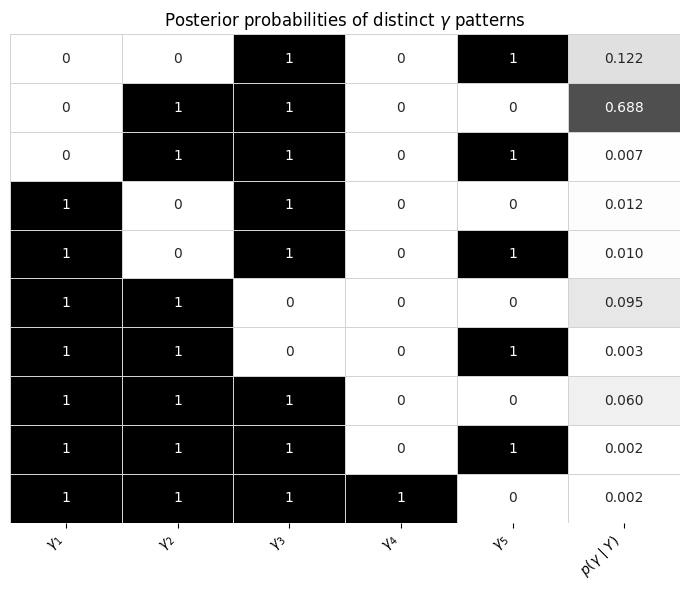

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# — replace this with your actual MCMC draws of gamma —
# e.g. store_gamma = OUT['store_gamma']
# For demo, let’s simulate:
# store_gamma = np.random.randint(0, 2, size=(1000, 5))
store_gamma = results['store_gamma']
# 1) find unique patterns and their frequencies
unique_gammas, counts = np.unique(store_gamma, axis=0, return_counts=True)
posterior_probs = counts / store_gamma.shape[0]

# 2) build annotation matrix of strings
n_patterns, q = unique_gammas.shape
annot = np.empty((n_patterns, q+1), dtype=object)
for i in range(n_patterns):
    # gamma cells: “0” or “1”
    for j in range(q):
        annot[i, j] = str(int(unique_gammas[i, j]))
    # probability cell: “0.xxx”
    annot[i, q] = f"{posterior_probs[i]:.3f}"

# 3) build data matrix for coloring (we’ll treat prob as a grayscale, too)
#    but you can pick a different cmap for the last column if you like
data = np.hstack((unique_gammas, posterior_probs[:, None]))

# 4) plot
plt.figure(figsize=(q+2, n_patterns*0.5 + 1))
sns.heatmap(
    data,
    annot=annot,
    fmt="",
    cmap="gray_r",
    cbar=False,
    linewidths=0.5,
    linecolor="lightgray",
    xticklabels=[f"$\\gamma_{{{i+1}}}$" for i in range(q)] + [r"$p(\gamma\mid Y)$"]
)
plt.yticks([])               # hide y‑tick labels (each row is a pattern)
plt.xticks(rotation=45, ha="right")
plt.title("Posterior probabilities of distinct $\gamma$ patterns")
plt.tight_layout()
plt.show()


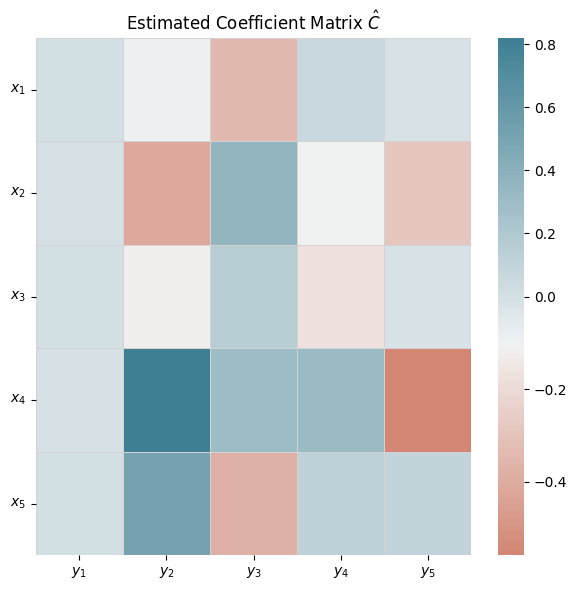

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

# Replace this with your actual matrix
# Chat2 = ...  # shape (p, q)
Chat2 = OUT2['Chat2']
p, q = Chat2.shape

# Set color scale limits
uplim = np.max(Chat2)  # same as max(abs(max), abs(min)) in MATLAB
lowlim = np.min(Chat2)
# Custom colormap (MATLAB’s 'colorC' likely means diverging colormap)
cmap = sns.diverging_palette(20, 220, as_cmap=True)  # Blue-White-Red style

# Plot heatmap
plt.figure(figsize=(6, 6))
ax = sns.heatmap(Chat2, cmap=cmap, center=0, cbar=True,
                 linewidths=0.5, linecolor='lightgray',
                 norm=TwoSlopeNorm(vmin=lowlim, vcenter=0, vmax=uplim))

# Format x-axis labels: $y_1$, $y_2$, ..., $y_q$
xtick_labels = [f'$y_{{{i+1}}}$' for i in range(q)]
ax.set_xticks(np.arange(q) + 0.5)
ax.set_xticklabels(xtick_labels, rotation=0)

# Format y-axis labels: $x_1$, $x_2$, ..., $x_p$
ytick_labels = [f'$x_{{{i+1}}}$' for i in range(p)]
ax.set_yticks(np.arange(p) + 0.5)
ax.set_yticklabels(ytick_labels, rotation=0)

# Tight layout
plt.title('Estimated Coefficient Matrix $\\hat{C}$')
plt.tight_layout()
plt.show()


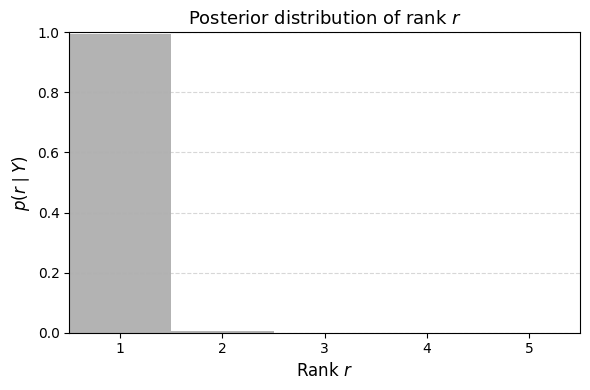

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual draw indices)
# store_r = OUT['store_r']
# idx_keep2 = OUT2['idx_keep2']
# burnin = ...

# Adjust index range as in MATLAB: store_r(burnin + idx_keep2)
r_draws = results['store_r']

# Create histogram
plt.figure(figsize=(6, 4))
plt.hist(r_draws, bins=np.arange(0.5, min(q, p) + 1.5, 1),  # bin edges at integers
         density=True, edgecolor='none', color=[0.7]*3)     # normalized histogram, grey color

# Formatting
plt.xticks(np.arange(1, q + 1))
plt.xlim(0.5, min(q, p) + 0.5)
plt.ylim(0, 1)
plt.ylabel(r'$p(r \mid Y)$', fontsize=12)
plt.xlabel(r'Rank $r$', fontsize=12)
plt.title('Posterior distribution of rank $r$', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
